# ===========================================================
# Solve the estimation problem with neural network tower model on the supervised dataset from the Jeopardy-like logs
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the neural network based model
3. Compute train and test error

#### Last update: 12 Dec 2019

# Imports

In [2]:
from __future__ import division, print_function, absolute_import, unicode_literals

import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report

sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytools import Timer

# Parameters

In [3]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data_Jan29.pk'
# data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data_roberta.pk'
test_fraction = 0.15
runs = 10

# Helper functions

In [4]:
def get_influence_on_others(A: np.ndarray, index: int) -> float:
    A = np.array(A)
    return sum(
        A[[i for i in range(len(A))
           if i != index], index])

In [5]:
def get_eigvec_of_laplacian(A: np.matrix) -> np.matrix:
#     D = np.diag(np.array(np.sum(A, axis=0))[0])
#     L = D - A
#     return np.matrix(np.linalg.eig(L)[1])
    n, m = A.shape
    diags = A.sum(axis=1).flatten()
    D = sp.sparse.spdiags(diags, [0], m, n, format='csr')
    L = D - A
    with sp.errstate(divide='ignore'):
        diags_sqrt = 1.0/sp.sqrt(diags)
    diags_sqrt[sp.isinf(diags_sqrt)] = 0
    DH = sp.sparse.spdiags(diags_sqrt, [0], m, n, format='csr')
    DH = DH.todense()
    normalized_L = DH.dot(L.dot(DH))
    return normalized_L

## Models

In [6]:
def my_logistic_regression(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000).fit(
        X_train, y_train)
    y_pred = lr.predict(X_test)
    return accuracy_score(y_test, y_pred)

def my_dummy_stratified(X_train, X_test, y_train, y_test):
    dummy_stratified = DummyClassifier(strategy='stratified').fit(
        X_train, y_train)
    y_pred = dummy_stratified.predict(X_test)
    return accuracy_score(y_test, y_pred)

def my_dummy_uniform(X_train, X_test, y_train, y_test):
    dummy_uniform = DummyClassifier(strategy='uniform').fit(
        X_train, y_train)
    y_pred = dummy_uniform.predict(X_test)
    return accuracy_score(y_test, y_pred)

def my_dummy_most_frequent(X_train, X_test, y_train, y_test):
    dummy_most_freq = DummyClassifier(strategy='most_frequent').fit(
        X_train, y_train)
    y_pred = dummy_most_freq.predict(X_test)
    return accuracy_score(y_test, y_pred)

def my_fc_nn(X_train, X_test, y_train, y_test, lambda1 = 0.01, epochs=400, batch_size=16):
    one_hot_y_train = []
    for sample in y_train:
        label = np.zeros(4)
        label[sample] = 1
        one_hot_y_train.append(label)
    one_hot_y_train = np.array(one_hot_y_train)

    input_dim = X_train.shape[1]
    model = Sequential([
        Dense(64,
              kernel_initializer='he_normal',
              activation='relu',
              input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(lambda1),
              activity_regularizer=regularizers.l1(lambda1)),
    #     Dropout(0.5),
    #     Dense(32,
    #           kernel_initializer='he_normal',
    #           activation='relu',
    #           kernel_regularizer=regularizers.l2(0.01),
    #           activity_regularizer=regularizers.l1(0.01)),
    #     Dropout(0.5),
        Dense(4, kernel_initializer='he_normal', activation='softmax')])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, one_hot_y_train, epochs=epochs, batch_size=batch_size)

    test_predicted = model.predict(X_test)
    model_y_pred = [np.argmax(predicted) for predicted in test_predicted]
    return accuracy_score(y_test, model_y_pred)

def my_conv_nn(X_train, X_test, y_train, y_test, lambda1 = 0.01, epochs=400, batch_size=16):
    one_hot_y_train = []
    for sample in y_train:
        label = np.zeros(4)
        label[sample] = 1
        one_hot_y_train.append(label)
    one_hot_y_train = np.array(one_hot_y_train)
    
    input_dim = X_train.shape[1]
    model2 = Sequential([
        Conv1D(
            32,
            2,
            kernel_initializer='he_normal',
            activation='relu',
            input_shape=(input_dim, 1),
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1)),
        Conv1D(
            32,
            2,
            kernel_initializer='he_normal',
            activation='relu',
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1)),
        MaxPooling1D(2),
        Conv1D(
            64,
            2,
            kernel_initializer='he_normal',
            activation='relu',
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1)),
        Conv1D(
            64,
            2,
            kernel_initializer='he_normal',
            activation='relu',
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1)),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(
            units=4,
            kernel_initializer='he_normal',
            activation='softmax',
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1))
    ])
    model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model2.fit(
        np.reshape(X_train, (len(X_train), input_dim, 1)),
        one_hot_y_train,
        epochs=epochs,
        batch_size=batch_size)

    test_predicted = model2.predict(np.reshape(X_test, (len(X_test), input_dim, 1)))
    model2_y_pred = [np.argmax(predicted) for predicted in test_predicted]

    return accuracy_score(y_test, model2_y_pred)

In [12]:
def get_classification_dataset(data_X, data_y, only_one_influential_is_allowed=False):
    classification_data = {}
    classification_data['X'] = []
    classification_data['y'] = []

    for i in range(len(data_y)):
        influence_matrix = data_y[i]['influence_matrix']
        how_influential_one_is = [get_influence_on_others(influence_matrix, index)
                                  for index in range(4)]
        most_influentials = np.where(how_influential_one_is == max(how_influential_one_is))[0]
        if len(most_influentials) > 1 and only_one_influential_is_allowed:
            continue
        for most_influencial_index in most_influentials:

            # Labels.
            classification_data['y'].append(most_influencial_index)

            # Features: what to pick from raw features to be the features in classification data.
            raw_features = data_X[i]

            features = np.hstack(
                [np.array(raw_features['first_influence_matrix'].flatten())[0],
                 np.array(raw_features['reply_duration'].flatten())[0],
                 np.array(raw_features['sentiment'].flatten())[0],
#                  raw_features['content_embedding_matrix'].flatten(),
                 raw_features['individual_performance_hardness_weighted']])

    #         features = np.array(raw_features['reply_duration'].flatten())[0]

#             features = raw_features['content_embedding_matrix'].flatten()
#             features = np.array(raw_features['first_influence_matrices'].flatten())[0]


            classification_data['X'].append(features)
    classification_data['X'] = np.array(classification_data['X'])
    classification_data['y'] = np.array(classification_data['y'])
    return classification_data

# Loading the data

In [8]:
data = utils.load_it(data_fpath)
print(len(data['X']))

264


# Finding the most influential person
### Making the matrix estimation problem into multi class classification problem

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
            data['X'],
            data['y'],
            test_size=test_fraction)
X_train, y_train = utils.replicate_matrices_in_train_dataset_with_reordering(
    X_train, y_train)

In [13]:
training_data = get_classification_dataset(X_train, y_train)
X_train = training_data['X']
y_train = training_data['y']
testing_data = get_classification_dataset(X_test, y_test)
X_test = testing_data['X']
y_test = testing_data['y']

In [14]:
X_train.shape

(6468, 52)

In [15]:
lr = LogisticRegression(penalty='l1', max_iter=1000).fit(
    X_train, y_train)
y_pred = lr.predict(X_test)
print( classification_report(y_test, y_pred) )

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.42      0.38      0.40        13
           2       0.36      0.44      0.40         9
           3       0.62      0.62      0.62        13

   micro avg       0.46      0.46      0.46        46
   macro avg       0.45      0.45      0.45        46
weighted avg       0.46      0.46      0.46        46



In [16]:
accuracy_score(y_test, y_pred)

0.45652173913043476

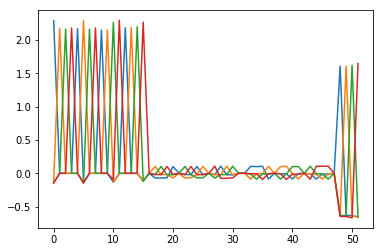

In [17]:
for i in range(4):
    plt.plot(lr.coef_[i])

# Classification

In [18]:
classification_data = get_classification_dataset(data['X'], data['y'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
            classification_data['X'],
            classification_data['y'],
            test_size=test_fraction)

lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000).fit(
    X_train, y_train)
y_pred = lr.predict(X_test)
print( classification_report(y_test, y_pred) )

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.50      0.18      0.27        11
           2       0.40      0.62      0.48        13
           3       0.58      0.50      0.54        14

   micro avg       0.49      0.49      0.49        47
   macro avg       0.51      0.49      0.47        47
weighted avg       0.51      0.49      0.47        47



In [20]:
with Timer():
    models = [my_logistic_regression, my_dummy_stratified, my_dummy_uniform, my_dummy_most_frequent, my_fc_nn, my_conv_nn]

    accuracies = defaultdict(list)
    for run in range(runs):
        print('Run', run, ' ...')
        X_train, X_test, y_train, y_test = train_test_split(
            classification_data['X'],
            classification_data['y'],
            stratify = classification_data['y'],
            test_size=test_fraction)

        for model in models:
            accuracies[model.__name__].append(
                model(X_train, X_test, y_train, y_test))

Run 0  ...


/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
265/265 [==============================] - 1s 3ms/sample - loss: 2.1256 - accuracy: 0.7075
Epoch 2/400
265/265 [==============================] - 0s 94us/sample - loss: 1.9048 - accuracy: 0.7396
Epoch 3/400
265/265 [==============================] - 0s 107us/sample - loss: 1.7406 - accuracy: 0.7415
Epoch 4/400
265/265 [==============================] - 0s 99us/sample - loss: 1.6004 - accuracy: 0.7472
Epoch 5/400
265/265 [==============================] - 0s 89us/sample - loss: 1.4791 - accuracy: 0.7500
Epoch 6/400
265/265 [==============================] - 0s 102us/sample - loss: 1.3767 - accuracy: 0.7509
Epoch 7/400
265/265 [==============================] - 0s 97us/sample - loss: 1.2863 - accuracy: 0.7519
Epoch 8/400
265/265 [==============================] - 0s 97us/sample - loss: 1.2076 - accuracy: 0.7528
Epoch 9/400
265/265 [==============================]

265/265 [==============================] - 0s 74us/sample - loss: 0.4944 - accuracy: 0.7925
Epoch 76/400
265/265 [==============================] - 0s 76us/sample - loss: 0.4937 - accuracy: 0.7925
Epoch 77/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4906 - accuracy: 0.7925
Epoch 78/400
265/265 [==============================] - 0s 78us/sample - loss: 0.4895 - accuracy: 0.7981
Epoch 79/400
265/265 [==============================] - 0s 80us/sample - loss: 0.4878 - accuracy: 0.8000
Epoch 80/400
265/265 [==============================] - 0s 77us/sample - loss: 0.4865 - accuracy: 0.8009
Epoch 81/400
265/265 [==============================] - 0s 77us/sample - loss: 0.4876 - accuracy: 0.7962
Epoch 82/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4852 - accuracy: 0.8019
Epoch 83/400
265/265 [==============================] - 0s 77us/sample - loss: 0.4847 - accuracy: 0.7953
Epoch 84/400
265/265 [==============================] - 0s 80us/samp

265/265 [==============================] - 0s 81us/sample - loss: 0.4161 - accuracy: 0.8528
Epoch 153/400
265/265 [==============================] - 0s 78us/sample - loss: 0.4145 - accuracy: 0.8575
Epoch 154/400
265/265 [==============================] - 0s 80us/sample - loss: 0.4133 - accuracy: 0.8604
Epoch 155/400
265/265 [==============================] - 0s 91us/sample - loss: 0.4143 - accuracy: 0.8594
Epoch 156/400
265/265 [==============================] - 0s 88us/sample - loss: 0.4146 - accuracy: 0.8575
Epoch 157/400
265/265 [==============================] - 0s 79us/sample - loss: 0.4131 - accuracy: 0.8566
Epoch 158/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4123 - accuracy: 0.8632
Epoch 159/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4117 - accuracy: 0.8594
Epoch 160/400
265/265 [==============================] - 0s 79us/sample - loss: 0.4105 - accuracy: 0.8651
Epoch 161/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 73us/sample - loss: 0.3691 - accuracy: 0.8811
Epoch 230/400
265/265 [==============================] - 0s 98us/sample - loss: 0.3681 - accuracy: 0.8868
Epoch 231/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3665 - accuracy: 0.8849
Epoch 232/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3690 - accuracy: 0.8821
Epoch 233/400
265/265 [==============================] - 0s 78us/sample - loss: 0.3679 - accuracy: 0.8811
Epoch 234/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3667 - accuracy: 0.8858
Epoch 235/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3656 - accuracy: 0.8858
Epoch 236/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3659 - accuracy: 0.8821
Epoch 237/400
265/265 [==============================] - 0s 88us/sample - loss: 0.3648 - accuracy: 0.8849
Epoch 238/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 126us/sample - loss: 0.3331 - accuracy: 0.8972
Epoch 307/400
265/265 [==============================] - 0s 98us/sample - loss: 0.3322 - accuracy: 0.9009
Epoch 308/400
265/265 [==============================] - 0s 120us/sample - loss: 0.3351 - accuracy: 0.8991
Epoch 309/400
265/265 [==============================] - 0s 107us/sample - loss: 0.3309 - accuracy: 0.9009
Epoch 310/400
265/265 [==============================] - 0s 110us/sample - loss: 0.3330 - accuracy: 0.8981
Epoch 311/400
265/265 [==============================] - 0s 114us/sample - loss: 0.3316 - accuracy: 0.8991
Epoch 312/400
265/265 [==============================] - 0s 100us/sample - loss: 0.3306 - accuracy: 0.8991
Epoch 313/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3319 - accuracy: 0.9038
Epoch 314/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3350 - accuracy: 0.8981
Epoch 315/400
265/265 [==============================]

265/265 [==============================] - 0s 78us/sample - loss: 0.3109 - accuracy: 0.9113
Epoch 384/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3125 - accuracy: 0.9057
Epoch 385/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3072 - accuracy: 0.9075
Epoch 386/400
265/265 [==============================] - 0s 97us/sample - loss: 0.3092 - accuracy: 0.9066
Epoch 387/400
265/265 [==============================] - 0s 87us/sample - loss: 0.3079 - accuracy: 0.9057
Epoch 388/400
265/265 [==============================] - 0s 81us/sample - loss: 0.3116 - accuracy: 0.9066
Epoch 389/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3071 - accuracy: 0.9113
Epoch 390/400
265/265 [==============================] - 0s 98us/sample - loss: 0.3033 - accuracy: 0.9113
Epoch 391/400
265/265 [==============================] - 0s 93us/sample - loss: 0.3061 - accuracy: 0.9104
Epoch 392/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 185us/sample - loss: 2.2073 - accuracy: 0.7500
Epoch 61/400
265/265 [==============================] - 0s 187us/sample - loss: 2.1613 - accuracy: 0.7500
Epoch 62/400
265/265 [==============================] - 0s 190us/sample - loss: 2.1163 - accuracy: 0.7500
Epoch 63/400
265/265 [==============================] - 0s 185us/sample - loss: 2.0734 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 193us/sample - loss: 2.0306 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 188us/sample - loss: 1.9893 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 207us/sample - loss: 1.9504 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 196us/sample - loss: 1.9118 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 198us/sample - loss: 1.8746 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 178us/sample - loss: 0.7688 - accuracy: 0.7500
Epoch 138/400
265/265 [==============================] - 0s 183us/sample - loss: 0.7631 - accuracy: 0.7500
Epoch 139/400
265/265 [==============================] - 0s 181us/sample - loss: 0.7578 - accuracy: 0.7500
Epoch 140/400
265/265 [==============================] - 0s 186us/sample - loss: 0.7523 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 205us/sample - loss: 0.7471 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 188us/sample - loss: 0.7421 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 183us/sample - loss: 0.7372 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 184us/sample - loss: 0.7326 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 191us/sample - loss: 0.7280 - accuracy: 0.7500
Epoch 146/400
265/265 [============================

265/265 [==============================] - 0s 184us/sample - loss: 0.5958 - accuracy: 0.7500
Epoch 214/400
265/265 [==============================] - 0s 201us/sample - loss: 0.5955 - accuracy: 0.7500
Epoch 215/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5952 - accuracy: 0.7500
Epoch 216/400
265/265 [==============================] - 0s 172us/sample - loss: 0.5950 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5947 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 176us/sample - loss: 0.5945 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 192us/sample - loss: 0.5942 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 246us/sample - loss: 0.5940 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 224us/sample - loss: 0.5938 - accuracy: 0.7500
Epoch 222/400
265/265 [============================

265/265 [==============================] - 0s 275us/sample - loss: 0.5864 - accuracy: 0.7500
Epoch 290/400
265/265 [==============================] - 0s 259us/sample - loss: 0.5863 - accuracy: 0.7500
Epoch 291/400
265/265 [==============================] - 0s 244us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 292/400
265/265 [==============================] - 0s 242us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 185us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 174us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 173us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 174us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 181us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 298/400
265/265 [============================

265/265 [==============================] - 0s 177us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 366/400
265/265 [==============================] - 0s 179us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 367/400
265/265 [==============================] - 0s 196us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 368/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 196us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 172us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 178us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 178us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 374/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 0s 2ms/sample - loss: 2.2250 - accuracy: 0.7104
Epoch 2/400
265/265 [==============================] - 0s 105us/sample - loss: 2.0000 - accuracy: 0.7340
Epoch 3/400
265/265 [==============================] - 0s 125us/sample - loss: 1.8392 - accuracy: 0.7462
Epoch 4/400
265/265 [==============================] - 0s 82us/sample - loss: 1.7018 - accuracy: 0.7509
Epoch 5/400
265/265 [==============================] - 0s 82us/sample - loss: 1.5790 - accuracy: 0.7519
Epoch 6/400
265/265 [==============================] - 0s 91us/sample - loss: 1.4736 - accuracy: 0.7538
Epoch 7/400
265/265 [==============================] - 0s 77us/sample - loss: 1.3777 - accuracy: 0.7575
Epoch 8/400
265/265 [==============================] - 0s 75us/sample - loss: 1.2912 - accuracy: 0.7557
Epoch 9/400
265/265 [==============================] - 0s 73us/sample - loss: 1.2154 - accuracy: 0.7547
Epoch 10/400
265/265 [====================

265/265 [==============================] - 0s 76us/sample - loss: 0.4946 - accuracy: 0.7991
Epoch 79/400
265/265 [==============================] - 0s 76us/sample - loss: 0.4926 - accuracy: 0.8019
Epoch 80/400
265/265 [==============================] - 0s 73us/sample - loss: 0.4916 - accuracy: 0.8009
Epoch 81/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4905 - accuracy: 0.8028
Epoch 82/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4880 - accuracy: 0.7991
Epoch 83/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4857 - accuracy: 0.8047
Epoch 84/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4857 - accuracy: 0.8066
Epoch 85/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4852 - accuracy: 0.8057
Epoch 86/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4843 - accuracy: 0.8057
Epoch 87/400
265/265 [==============================] - 0s 74us/samp

265/265 [==============================] - 0s 72us/sample - loss: 0.4171 - accuracy: 0.8481
Epoch 156/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4185 - accuracy: 0.8509
Epoch 157/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4184 - accuracy: 0.8434
Epoch 158/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4151 - accuracy: 0.8538
Epoch 159/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4136 - accuracy: 0.8585
Epoch 160/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4150 - accuracy: 0.8491
Epoch 161/400
265/265 [==============================] - 0s 79us/sample - loss: 0.4136 - accuracy: 0.8509
Epoch 162/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4108 - accuracy: 0.8547
Epoch 163/400
265/265 [==============================] - 0s 106us/sample - loss: 0.4109 - accuracy: 0.8575
Epoch 164/400
265/265 [==============================] - 0s

265/265 [==============================] - 0s 72us/sample - loss: 0.3721 - accuracy: 0.8792
Epoch 233/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3700 - accuracy: 0.8830
Epoch 234/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3688 - accuracy: 0.8821
Epoch 235/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3675 - accuracy: 0.8830
Epoch 236/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3674 - accuracy: 0.8858
Epoch 237/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3688 - accuracy: 0.8849
Epoch 238/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3668 - accuracy: 0.8849
Epoch 239/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3654 - accuracy: 0.8858
Epoch 240/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3652 - accuracy: 0.8830
Epoch 241/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 72us/sample - loss: 0.3367 - accuracy: 0.8962
Epoch 310/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3380 - accuracy: 0.9000
Epoch 311/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3379 - accuracy: 0.9000
Epoch 312/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3380 - accuracy: 0.8962
Epoch 313/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3367 - accuracy: 0.9000
Epoch 314/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3362 - accuracy: 0.9019
Epoch 315/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3345 - accuracy: 0.8991
Epoch 316/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3380 - accuracy: 0.8906
Epoch 317/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3303 - accuracy: 0.9019
Epoch 318/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 74us/sample - loss: 0.3110 - accuracy: 0.9085
Epoch 387/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3083 - accuracy: 0.9104
Epoch 388/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3098 - accuracy: 0.9047
Epoch 389/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3085 - accuracy: 0.9066
Epoch 390/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3086 - accuracy: 0.9132
Epoch 391/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3086 - accuracy: 0.9075
Epoch 392/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3057 - accuracy: 0.9104
Epoch 393/400
265/265 [==============================] - 0s 115us/sample - loss: 0.3068 - accuracy: 0.9113
Epoch 394/400
265/265 [==============================] - 0s 89us/sample - loss: 0.3069 - accuracy: 0.9113
Epoch 395/400
265/265 [==============================] - 0s

265/265 [==============================] - 0s 191us/sample - loss: 1.7057 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 183us/sample - loss: 1.6719 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 180us/sample - loss: 1.6384 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 210us/sample - loss: 1.6066 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 192us/sample - loss: 1.5761 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 185us/sample - loss: 1.5461 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 193us/sample - loss: 1.5175 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 191us/sample - loss: 1.4896 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 196us/sample - loss: 1.4621 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 181us/sample - loss: 0.6660 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 182us/sample - loss: 0.6631 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 188us/sample - loss: 0.6602 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 205us/sample - loss: 0.6576 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 202us/sample - loss: 0.6550 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 171us/sample - loss: 0.6526 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 254us/sample - loss: 0.6502 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 199us/sample - loss: 0.6480 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 179us/sample - loss: 0.6461 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 183us/sample - loss: 0.5935 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 193us/sample - loss: 0.5933 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 197us/sample - loss: 0.5931 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 181us/sample - loss: 0.5930 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 181us/sample - loss: 0.5929 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 176us/sample - loss: 0.5926 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5925 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 184us/sample - loss: 0.5922 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 188us/sample - loss: 0.5922 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 176us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 180us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 175us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 196us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 198us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 192us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 185us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 189us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 184us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 264us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 271us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 274us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 229us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 173us/sample - loss: 0.5863 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 170us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 169us/sample - loss: 0.5863 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 167us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 167us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 0s 2ms/sample - loss: 2.0514 - accuracy: 0.7274
Epoch 2/400
265/265 [==============================] - 0s 105us/sample - loss: 1.8595 - accuracy: 0.7415
Epoch 3/400
265/265 [==============================] - 0s 88us/sample - loss: 1.7113 - accuracy: 0.7472
Epoch 4/400
265/265 [==============================] - 0s 91us/sample - loss: 1.5800 - accuracy: 0.7491
Epoch 5/400
265/265 [==============================] - 0s 78us/sample - loss: 1.4660 - accuracy: 0.7472
Epoch 6/400
265/265 [==============================] - 0s 78us/sample - loss: 1.3651 - accuracy: 0.7491
Epoch 7/400
265/265 [==============================] - 0s 80us/sample - loss: 1.2747 - accuracy: 0.7500
Epoch 8/400
265/265 [==============================] - 0s 75us/sample - loss: 1.1951 - accuracy: 0.7519
Epoch 9/400
265/265 [==============================] - 0s 74us/sample - loss: 1.1249 - accuracy: 0.7509
Epoch 10/400
265/265 [=====================

265/265 [==============================] - 0s 71us/sample - loss: 0.4771 - accuracy: 0.8160
Epoch 79/400
265/265 [==============================] - 0s 77us/sample - loss: 0.4755 - accuracy: 0.8170
Epoch 80/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4742 - accuracy: 0.8151
Epoch 81/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4726 - accuracy: 0.8189
Epoch 82/400
265/265 [==============================] - 0s 73us/sample - loss: 0.4729 - accuracy: 0.8189
Epoch 83/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4711 - accuracy: 0.8179
Epoch 84/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4690 - accuracy: 0.8179
Epoch 85/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4684 - accuracy: 0.8226
Epoch 86/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4683 - accuracy: 0.8226
Epoch 87/400
265/265 [==============================] - 0s 73us/samp

265/265 [==============================] - 0s 72us/sample - loss: 0.4031 - accuracy: 0.8708
Epoch 156/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4041 - accuracy: 0.8660
Epoch 157/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4035 - accuracy: 0.8698
Epoch 158/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4002 - accuracy: 0.8708
Epoch 159/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4000 - accuracy: 0.8689
Epoch 160/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3975 - accuracy: 0.8764
Epoch 161/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3977 - accuracy: 0.8736
Epoch 162/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3955 - accuracy: 0.8717
Epoch 163/400
265/265 [==============================] - 0s 81us/sample - loss: 0.3958 - accuracy: 0.8717
Epoch 164/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 73us/sample - loss: 0.3579 - accuracy: 0.8925
Epoch 233/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3568 - accuracy: 0.8962
Epoch 234/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3581 - accuracy: 0.8915
Epoch 235/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3558 - accuracy: 0.8972
Epoch 236/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3519 - accuracy: 0.8972
Epoch 237/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3547 - accuracy: 0.8962
Epoch 238/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3577 - accuracy: 0.8887
Epoch 239/400
265/265 [==============================] - 0s 78us/sample - loss: 0.3536 - accuracy: 0.8906
Epoch 240/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3514 - accuracy: 0.8934
Epoch 241/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 71us/sample - loss: 0.3240 - accuracy: 0.9151
Epoch 310/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3228 - accuracy: 0.9151
Epoch 311/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3220 - accuracy: 0.9189
Epoch 312/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3215 - accuracy: 0.9179
Epoch 313/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3232 - accuracy: 0.9104
Epoch 314/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3249 - accuracy: 0.9113
Epoch 315/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3256 - accuracy: 0.9160
Epoch 316/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3220 - accuracy: 0.9123
Epoch 317/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3219 - accuracy: 0.9151
Epoch 318/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 74us/sample - loss: 0.2996 - accuracy: 0.9208
Epoch 387/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3006 - accuracy: 0.9226
Epoch 388/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3036 - accuracy: 0.9208
Epoch 389/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3016 - accuracy: 0.9189
Epoch 390/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3003 - accuracy: 0.9245
Epoch 391/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3036 - accuracy: 0.9151
Epoch 392/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3041 - accuracy: 0.9226
Epoch 393/400
265/265 [==============================] - 0s 72us/sample - loss: 0.2985 - accuracy: 0.9236
Epoch 394/400
265/265 [==============================] - 0s 73us/sample - loss: 0.2960 - accuracy: 0.9245
Epoch 395/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 201us/sample - loss: 1.8574 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 223us/sample - loss: 1.8209 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 205us/sample - loss: 1.7845 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 206us/sample - loss: 1.7491 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 195us/sample - loss: 1.7156 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 200us/sample - loss: 1.6821 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 212us/sample - loss: 1.6497 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 206us/sample - loss: 1.6189 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 219us/sample - loss: 1.5888 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 201us/sample - loss: 0.7176 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 195us/sample - loss: 0.7137 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 186us/sample - loss: 0.7099 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 178us/sample - loss: 0.7063 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 179us/sample - loss: 0.7028 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 179us/sample - loss: 0.6994 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 184us/sample - loss: 0.6962 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 170us/sample - loss: 0.6930 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 190us/sample - loss: 0.6901 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 185us/sample - loss: 0.6076 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 199us/sample - loss: 0.6070 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 182us/sample - loss: 0.6065 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 176us/sample - loss: 0.6061 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 188us/sample - loss: 0.6055 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 175us/sample - loss: 0.6051 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 169us/sample - loss: 0.6045 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 170us/sample - loss: 0.6042 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 170us/sample - loss: 0.6036 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 171us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 175us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 180us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 175us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 188us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 190us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 169us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 171us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 173us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 169us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 182us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 179us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 174us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 183us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 0s 2ms/sample - loss: 2.1419 - accuracy: 0.7274
Epoch 2/400
265/265 [==============================] - 0s 99us/sample - loss: 1.9413 - accuracy: 0.7349
Epoch 3/400
265/265 [==============================] - 0s 99us/sample - loss: 1.7768 - accuracy: 0.7396
Epoch 4/400
265/265 [==============================] - 0s 91us/sample - loss: 1.6373 - accuracy: 0.7425
Epoch 5/400
265/265 [==============================] - 0s 84us/sample - loss: 1.5148 - accuracy: 0.7481
Epoch 6/400
265/265 [==============================] - 0s 76us/sample - loss: 1.4101 - accuracy: 0.7472
Epoch 7/400
265/265 [==============================] - 0s 80us/sample - loss: 1.3171 - accuracy: 0.7472
Epoch 8/400
265/265 [==============================] - 0s 74us/sample - loss: 1.2353 - accuracy: 0.7481
Epoch 9/400
265/265 [==============================] - 0s 92us/sample - loss: 1.1637 - accuracy: 0.7519
Epoch 10/400
265/265 [======================

265/265 [==============================] - 0s 104us/sample - loss: 0.4951 - accuracy: 0.7906
Epoch 79/400
265/265 [==============================] - 0s 124us/sample - loss: 0.4950 - accuracy: 0.7991
Epoch 80/400
265/265 [==============================] - 0s 87us/sample - loss: 0.4931 - accuracy: 0.7925
Epoch 81/400
265/265 [==============================] - 0s 108us/sample - loss: 0.4909 - accuracy: 0.7981
Epoch 82/400
265/265 [==============================] - 0s 93us/sample - loss: 0.4886 - accuracy: 0.8000
Epoch 83/400
265/265 [==============================] - 0s 107us/sample - loss: 0.4866 - accuracy: 0.8028
Epoch 84/400
265/265 [==============================] - 0s 113us/sample - loss: 0.4874 - accuracy: 0.8019
Epoch 85/400
265/265 [==============================] - 0s 86us/sample - loss: 0.4865 - accuracy: 0.7972
Epoch 86/400
265/265 [==============================] - 0s 103us/sample - loss: 0.4841 - accuracy: 0.7981
Epoch 87/400
265/265 [==============================] - 0s 101

265/265 [==============================] - 0s 72us/sample - loss: 0.4142 - accuracy: 0.8698
Epoch 156/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4139 - accuracy: 0.8660
Epoch 157/400
265/265 [==============================] - 0s 88us/sample - loss: 0.4127 - accuracy: 0.8736
Epoch 158/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4118 - accuracy: 0.8689
Epoch 159/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4101 - accuracy: 0.8708
Epoch 160/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4098 - accuracy: 0.8726
Epoch 161/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4115 - accuracy: 0.8708
Epoch 162/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4073 - accuracy: 0.8726
Epoch 163/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4091 - accuracy: 0.8736
Epoch 164/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 80us/sample - loss: 0.3648 - accuracy: 0.8877
Epoch 233/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3635 - accuracy: 0.8896
Epoch 234/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3641 - accuracy: 0.8868
Epoch 235/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3617 - accuracy: 0.8877
Epoch 236/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3617 - accuracy: 0.8887
Epoch 237/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3623 - accuracy: 0.8925
Epoch 238/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3644 - accuracy: 0.8906
Epoch 239/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3601 - accuracy: 0.8906
Epoch 240/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3620 - accuracy: 0.8877
Epoch 241/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 72us/sample - loss: 0.3307 - accuracy: 0.9075
Epoch 310/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3303 - accuracy: 0.9028
Epoch 311/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3312 - accuracy: 0.9038
Epoch 312/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3294 - accuracy: 0.9047
Epoch 313/400
265/265 [==============================] - 0s 78us/sample - loss: 0.3291 - accuracy: 0.9047
Epoch 314/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3293 - accuracy: 0.9038
Epoch 315/400
265/265 [==============================] - 0s 93us/sample - loss: 0.3302 - accuracy: 0.9075
Epoch 316/400
265/265 [==============================] - 0s 81us/sample - loss: 0.3311 - accuracy: 0.9047
Epoch 317/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3310 - accuracy: 0.9057
Epoch 318/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 75us/sample - loss: 0.3069 - accuracy: 0.9123
Epoch 387/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3082 - accuracy: 0.9104
Epoch 388/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3095 - accuracy: 0.9132
Epoch 389/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3100 - accuracy: 0.9123
Epoch 390/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3053 - accuracy: 0.9151
Epoch 391/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3062 - accuracy: 0.9132
Epoch 392/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3056 - accuracy: 0.9104
Epoch 393/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3098 - accuracy: 0.9123
Epoch 394/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3052 - accuracy: 0.9132
Epoch 395/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 173us/sample - loss: 1.9016 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 177us/sample - loss: 1.8652 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 174us/sample - loss: 1.8291 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 172us/sample - loss: 1.7942 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 173us/sample - loss: 1.7600 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 170us/sample - loss: 1.7271 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 165us/sample - loss: 1.6951 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 173us/sample - loss: 1.6640 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 177us/sample - loss: 1.6337 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 174us/sample - loss: 0.7310 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 169us/sample - loss: 0.7270 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 178us/sample - loss: 0.7232 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 172us/sample - loss: 0.7195 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 179us/sample - loss: 0.7158 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 170us/sample - loss: 0.7123 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 176us/sample - loss: 0.7089 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 181us/sample - loss: 0.7056 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 171us/sample - loss: 0.7023 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 172us/sample - loss: 0.6021 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 180us/sample - loss: 0.6016 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 179us/sample - loss: 0.6011 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 187us/sample - loss: 0.6006 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 174us/sample - loss: 0.6000 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 174us/sample - loss: 0.5996 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 179us/sample - loss: 0.5991 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 192us/sample - loss: 0.5986 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 175us/sample - loss: 0.5981 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 180us/sample - loss: 0.5892 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 180us/sample - loss: 0.5891 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 187us/sample - loss: 0.5890 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5889 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 178us/sample - loss: 0.5888 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 191us/sample - loss: 0.5887 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 173us/sample - loss: 0.5886 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5885 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 174us/sample - loss: 0.5884 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 169us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 191us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 178us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 172us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 170us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 170us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 0s 2ms/sample - loss: 2.1652 - accuracy: 0.7151
Epoch 2/400
265/265 [==============================] - 0s 112us/sample - loss: 1.9559 - accuracy: 0.7425
Epoch 3/400
265/265 [==============================] - 0s 110us/sample - loss: 1.7938 - accuracy: 0.7462
Epoch 4/400
265/265 [==============================] - 0s 98us/sample - loss: 1.6610 - accuracy: 0.7472
Epoch 5/400
265/265 [==============================] - 0s 105us/sample - loss: 1.5419 - accuracy: 0.7509
Epoch 6/400
265/265 [==============================] - 0s 95us/sample - loss: 1.4369 - accuracy: 0.7538
Epoch 7/400
265/265 [==============================] - 0s 101us/sample - loss: 1.3429 - accuracy: 0.7566
Epoch 8/400
265/265 [==============================] - 0s 86us/sample - loss: 1.2600 - accuracy: 0.7557
Epoch 9/400
265/265 [==============================] - 0s 93us/sample - loss: 1.1855 - accuracy: 0.7585
Epoch 10/400
265/265 [==================

265/265 [==============================] - 0s 74us/sample - loss: 0.4898 - accuracy: 0.7915
Epoch 79/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4875 - accuracy: 0.7953
Epoch 80/400
265/265 [==============================] - 0s 84us/sample - loss: 0.4887 - accuracy: 0.7981
Epoch 81/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4865 - accuracy: 0.7943
Epoch 82/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4850 - accuracy: 0.7981
Epoch 83/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4846 - accuracy: 0.8038
Epoch 84/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4808 - accuracy: 0.8009
Epoch 85/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4781 - accuracy: 0.8085
Epoch 86/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4785 - accuracy: 0.8047
Epoch 87/400
265/265 [==============================] - 0s 74us/samp

265/265 [==============================] - 0s 88us/sample - loss: 0.4008 - accuracy: 0.8726
Epoch 156/400
265/265 [==============================] - 0s 95us/sample - loss: 0.4008 - accuracy: 0.8745
Epoch 157/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3981 - accuracy: 0.8811
Epoch 158/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3983 - accuracy: 0.8745
Epoch 159/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3986 - accuracy: 0.8755
Epoch 160/400
265/265 [==============================] - 0s 73us/sample - loss: 0.4009 - accuracy: 0.8726
Epoch 161/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3989 - accuracy: 0.8783
Epoch 162/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3970 - accuracy: 0.8745
Epoch 163/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3953 - accuracy: 0.8774
Epoch 164/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 71us/sample - loss: 0.3506 - accuracy: 0.8981
Epoch 233/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3510 - accuracy: 0.8962
Epoch 234/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3502 - accuracy: 0.8991
Epoch 235/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3526 - accuracy: 0.8953
Epoch 236/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3503 - accuracy: 0.8981
Epoch 237/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3477 - accuracy: 0.9038
Epoch 238/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3471 - accuracy: 0.9028
Epoch 239/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3496 - accuracy: 0.8962
Epoch 240/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3468 - accuracy: 0.9028
Epoch 241/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 75us/sample - loss: 0.3229 - accuracy: 0.9113
Epoch 310/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3194 - accuracy: 0.9123
Epoch 311/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3188 - accuracy: 0.9151
Epoch 312/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3167 - accuracy: 0.9142
Epoch 313/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3186 - accuracy: 0.9085
Epoch 314/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3151 - accuracy: 0.9151
Epoch 315/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3188 - accuracy: 0.9094
Epoch 316/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3145 - accuracy: 0.9151
Epoch 317/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3149 - accuracy: 0.9151
Epoch 318/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 72us/sample - loss: 0.3031 - accuracy: 0.9170
Epoch 387/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3009 - accuracy: 0.9113
Epoch 388/400
265/265 [==============================] - 0s 76us/sample - loss: 0.2936 - accuracy: 0.9208
Epoch 389/400
265/265 [==============================] - 0s 75us/sample - loss: 0.2953 - accuracy: 0.9189
Epoch 390/400
265/265 [==============================] - 0s 72us/sample - loss: 0.2929 - accuracy: 0.9198
Epoch 391/400
265/265 [==============================] - 0s 74us/sample - loss: 0.2940 - accuracy: 0.9189
Epoch 392/400
265/265 [==============================] - 0s 77us/sample - loss: 0.2930 - accuracy: 0.9189
Epoch 393/400
265/265 [==============================] - 0s 71us/sample - loss: 0.2900 - accuracy: 0.9217
Epoch 394/400
265/265 [==============================] - 0s 70us/sample - loss: 0.2965 - accuracy: 0.9198
Epoch 395/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 188us/sample - loss: 1.8713 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 198us/sample - loss: 1.8344 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 177us/sample - loss: 1.7982 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 196us/sample - loss: 1.7634 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 215us/sample - loss: 1.7297 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 189us/sample - loss: 1.6971 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 207us/sample - loss: 1.6657 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 210us/sample - loss: 1.6351 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 206us/sample - loss: 1.6057 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 183us/sample - loss: 0.7328 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 174us/sample - loss: 0.7287 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 182us/sample - loss: 0.7247 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 199us/sample - loss: 0.7210 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 192us/sample - loss: 0.7172 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 192us/sample - loss: 0.7135 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 176us/sample - loss: 0.7099 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 173us/sample - loss: 0.7063 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 190us/sample - loss: 0.7029 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 199us/sample - loss: 0.6063 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 217us/sample - loss: 0.6058 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 215us/sample - loss: 0.6050 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 203us/sample - loss: 0.6045 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 211us/sample - loss: 0.6040 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 209us/sample - loss: 0.6033 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 237us/sample - loss: 0.6028 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 204us/sample - loss: 0.6022 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 221us/sample - loss: 0.6018 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 201us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 214us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 202us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 169us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 184us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 189us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 179us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 170us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 217us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 182us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 178us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 186us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 182us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 173us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 187us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 0s 2ms/sample - loss: 2.2492 - accuracy: 0.7160
Epoch 2/400
265/265 [==============================] - 0s 84us/sample - loss: 2.0121 - accuracy: 0.7349
Epoch 3/400
265/265 [==============================] - 0s 85us/sample - loss: 1.8265 - accuracy: 0.7425
Epoch 4/400
265/265 [==============================] - 0s 83us/sample - loss: 1.6787 - accuracy: 0.7434
Epoch 5/400
265/265 [==============================] - 0s 84us/sample - loss: 1.5507 - accuracy: 0.7443
Epoch 6/400
265/265 [==============================] - 0s 84us/sample - loss: 1.4378 - accuracy: 0.7491
Epoch 7/400
265/265 [==============================] - 0s 88us/sample - loss: 1.3397 - accuracy: 0.7500
Epoch 8/400
265/265 [==============================] - 0s 89us/sample - loss: 1.2543 - accuracy: 0.7500
Epoch 9/400
265/265 [==============================] - 0s 81us/sample - loss: 1.1782 - accuracy: 0.7519
Epoch 10/400
265/265 [======================

265/265 [==============================] - 0s 73us/sample - loss: 0.4896 - accuracy: 0.7972
Epoch 79/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4911 - accuracy: 0.8000
Epoch 80/400
265/265 [==============================] - 0s 73us/sample - loss: 0.4895 - accuracy: 0.8000
Epoch 81/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4901 - accuracy: 0.8019
Epoch 82/400
265/265 [==============================] - 0s 73us/sample - loss: 0.4869 - accuracy: 0.8028
Epoch 83/400
265/265 [==============================] - 0s 73us/sample - loss: 0.4833 - accuracy: 0.8028
Epoch 84/400
265/265 [==============================] - 0s 86us/sample - loss: 0.4818 - accuracy: 0.8038
Epoch 85/400
265/265 [==============================] - 0s 84us/sample - loss: 0.4809 - accuracy: 0.8047
Epoch 86/400
265/265 [==============================] - 0s 87us/sample - loss: 0.4799 - accuracy: 0.8047
Epoch 87/400
265/265 [==============================] - 0s 81us/samp

265/265 [==============================] - 0s 78us/sample - loss: 0.4171 - accuracy: 0.8585
Epoch 156/400
265/265 [==============================] - 0s 84us/sample - loss: 0.4123 - accuracy: 0.8623
Epoch 157/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4109 - accuracy: 0.8613
Epoch 158/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4150 - accuracy: 0.8585
Epoch 159/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4120 - accuracy: 0.8594
Epoch 160/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4095 - accuracy: 0.8632
Epoch 161/400
265/265 [==============================] - 0s 81us/sample - loss: 0.4081 - accuracy: 0.8623
Epoch 162/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4066 - accuracy: 0.8670
Epoch 163/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4057 - accuracy: 0.8660
Epoch 164/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 81us/sample - loss: 0.3670 - accuracy: 0.8868
Epoch 233/400
265/265 [==============================] - 0s 83us/sample - loss: 0.3642 - accuracy: 0.8915
Epoch 234/400
265/265 [==============================] - 0s 78us/sample - loss: 0.3608 - accuracy: 0.8915
Epoch 235/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3623 - accuracy: 0.8877
Epoch 236/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3611 - accuracy: 0.8915
Epoch 237/400
265/265 [==============================] - 0s 80us/sample - loss: 0.3592 - accuracy: 0.8887
Epoch 238/400
265/265 [==============================] - 0s 110us/sample - loss: 0.3592 - accuracy: 0.8868
Epoch 239/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3604 - accuracy: 0.8925
Epoch 240/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3573 - accuracy: 0.8896
Epoch 241/400
265/265 [==============================] - 0s

265/265 [==============================] - 0s 85us/sample - loss: 0.3300 - accuracy: 0.9028
Epoch 310/400
265/265 [==============================] - 0s 83us/sample - loss: 0.3305 - accuracy: 0.9000
Epoch 311/400
265/265 [==============================] - 0s 84us/sample - loss: 0.3278 - accuracy: 0.8981
Epoch 312/400
265/265 [==============================] - 0s 82us/sample - loss: 0.3278 - accuracy: 0.9047
Epoch 313/400
265/265 [==============================] - 0s 82us/sample - loss: 0.3279 - accuracy: 0.9038
Epoch 314/400
265/265 [==============================] - 0s 84us/sample - loss: 0.3294 - accuracy: 0.9009
Epoch 315/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3304 - accuracy: 0.8991
Epoch 316/400
265/265 [==============================] - 0s 86us/sample - loss: 0.3273 - accuracy: 0.8981
Epoch 317/400
265/265 [==============================] - 0s 80us/sample - loss: 0.3265 - accuracy: 0.9019
Epoch 318/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 71us/sample - loss: 0.3049 - accuracy: 0.9047
Epoch 387/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3052 - accuracy: 0.9075
Epoch 388/400
265/265 [==============================] - 0s 78us/sample - loss: 0.3055 - accuracy: 0.9104
Epoch 389/400
265/265 [==============================] - 0s 87us/sample - loss: 0.3056 - accuracy: 0.9113
Epoch 390/400
265/265 [==============================] - 0s 89us/sample - loss: 0.3068 - accuracy: 0.9047
Epoch 391/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3070 - accuracy: 0.9123
Epoch 392/400
265/265 [==============================] - 0s 81us/sample - loss: 0.3075 - accuracy: 0.9085
Epoch 393/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3038 - accuracy: 0.9113
Epoch 394/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3039 - accuracy: 0.9113
Epoch 395/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 189us/sample - loss: 2.2057 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 204us/sample - loss: 2.1581 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 212us/sample - loss: 2.1117 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 204us/sample - loss: 2.0668 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 214us/sample - loss: 2.0238 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 214us/sample - loss: 1.9811 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 229us/sample - loss: 1.9400 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 220us/sample - loss: 1.9003 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 212us/sample - loss: 1.8611 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 229us/sample - loss: 0.7271 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 204us/sample - loss: 0.7232 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 185us/sample - loss: 0.7191 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 177us/sample - loss: 0.7156 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 196us/sample - loss: 0.7118 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 189us/sample - loss: 0.7084 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 184us/sample - loss: 0.7051 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 188us/sample - loss: 0.7019 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 169us/sample - loss: 0.6987 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 210us/sample - loss: 0.6017 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 225us/sample - loss: 0.6011 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 215us/sample - loss: 0.6005 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 207us/sample - loss: 0.5999 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 202us/sample - loss: 0.5992 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 202us/sample - loss: 0.5987 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 205us/sample - loss: 0.5980 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 172us/sample - loss: 0.5975 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 175us/sample - loss: 0.5968 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 166us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 183us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 176us/sample - loss: 0.5856 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 183us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 193us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 183us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 172us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 179us/sample - loss: 0.5856 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 167us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 200us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 179us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 174us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 220us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 0s 2ms/sample - loss: 2.1653 - accuracy: 0.7160
Epoch 2/400
265/265 [==============================] - 0s 78us/sample - loss: 1.9693 - accuracy: 0.7302
Epoch 3/400
265/265 [==============================] - 0s 82us/sample - loss: 1.8102 - accuracy: 0.7377
Epoch 4/400
265/265 [==============================] - 0s 79us/sample - loss: 1.6703 - accuracy: 0.7358
Epoch 5/400
265/265 [==============================] - 0s 86us/sample - loss: 1.5496 - accuracy: 0.7434
Epoch 6/400
265/265 [==============================] - 0s 79us/sample - loss: 1.4414 - accuracy: 0.7491
Epoch 7/400
265/265 [==============================] - 0s 81us/sample - loss: 1.3485 - accuracy: 0.7519
Epoch 8/400
265/265 [==============================] - 0s 86us/sample - loss: 1.2649 - accuracy: 0.7547
Epoch 9/400
265/265 [==============================] - 0s 83us/sample - loss: 1.1929 - accuracy: 0.7547
Epoch 10/400
265/265 [======================

265/265 [==============================] - 0s 82us/sample - loss: 0.5049 - accuracy: 0.7868
Epoch 79/400
265/265 [==============================] - 0s 84us/sample - loss: 0.5029 - accuracy: 0.7887
Epoch 80/400
265/265 [==============================] - 0s 74us/sample - loss: 0.5034 - accuracy: 0.7915
Epoch 81/400
265/265 [==============================] - 0s 70us/sample - loss: 0.5027 - accuracy: 0.7896
Epoch 82/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4996 - accuracy: 0.7906
Epoch 83/400
265/265 [==============================] - 0s 69us/sample - loss: 0.4988 - accuracy: 0.7887
Epoch 84/400
265/265 [==============================] - 0s 78us/sample - loss: 0.4973 - accuracy: 0.7887
Epoch 85/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4947 - accuracy: 0.7906
Epoch 86/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4941 - accuracy: 0.7915
Epoch 87/400
265/265 [==============================] - 0s 75us/samp

265/265 [==============================] - 0s 81us/sample - loss: 0.4257 - accuracy: 0.8462
Epoch 156/400
265/265 [==============================] - 0s 86us/sample - loss: 0.4240 - accuracy: 0.8481
Epoch 157/400
265/265 [==============================] - 0s 86us/sample - loss: 0.4235 - accuracy: 0.8538
Epoch 158/400
265/265 [==============================] - 0s 91us/sample - loss: 0.4227 - accuracy: 0.8538
Epoch 159/400
265/265 [==============================] - 0s 128us/sample - loss: 0.4204 - accuracy: 0.8509
Epoch 160/400
265/265 [==============================] - 0s 87us/sample - loss: 0.4211 - accuracy: 0.8481
Epoch 161/400
265/265 [==============================] - 0s 88us/sample - loss: 0.4208 - accuracy: 0.8491
Epoch 162/400
265/265 [==============================] - 0s 81us/sample - loss: 0.4195 - accuracy: 0.8538
Epoch 163/400
265/265 [==============================] - 0s 88us/sample - loss: 0.4184 - accuracy: 0.8557
Epoch 164/400
265/265 [==============================] - 0s

265/265 [==============================] - 0s 78us/sample - loss: 0.3726 - accuracy: 0.8840
Epoch 233/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3735 - accuracy: 0.8868
Epoch 234/400
265/265 [==============================] - 0s 84us/sample - loss: 0.3715 - accuracy: 0.8849
Epoch 235/400
265/265 [==============================] - 0s 84us/sample - loss: 0.3710 - accuracy: 0.8840
Epoch 236/400
265/265 [==============================] - 0s 81us/sample - loss: 0.3697 - accuracy: 0.8858
Epoch 237/400
265/265 [==============================] - 0s 83us/sample - loss: 0.3694 - accuracy: 0.8849
Epoch 238/400
265/265 [==============================] - 0s 80us/sample - loss: 0.3694 - accuracy: 0.8858
Epoch 239/400
265/265 [==============================] - 0s 95us/sample - loss: 0.3675 - accuracy: 0.8887
Epoch 240/400
265/265 [==============================] - 0s 89us/sample - loss: 0.3689 - accuracy: 0.8887
Epoch 241/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 103us/sample - loss: 0.3344 - accuracy: 0.9075
Epoch 310/400
265/265 [==============================] - 0s 81us/sample - loss: 0.3351 - accuracy: 0.9085
Epoch 311/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3349 - accuracy: 0.9066
Epoch 312/400
265/265 [==============================] - 0s 80us/sample - loss: 0.3343 - accuracy: 0.9047
Epoch 313/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3322 - accuracy: 0.9075
Epoch 314/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3339 - accuracy: 0.9075
Epoch 315/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3336 - accuracy: 0.9094
Epoch 316/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3310 - accuracy: 0.9085
Epoch 317/400
265/265 [==============================] - 0s 86us/sample - loss: 0.3339 - accuracy: 0.9057
Epoch 318/400
265/265 [==============================] - 0s

265/265 [==============================] - 0s 89us/sample - loss: 0.3064 - accuracy: 0.9179
Epoch 387/400
265/265 [==============================] - 0s 86us/sample - loss: 0.3081 - accuracy: 0.9170
Epoch 388/400
265/265 [==============================] - 0s 80us/sample - loss: 0.3148 - accuracy: 0.9113
Epoch 389/400
265/265 [==============================] - 0s 83us/sample - loss: 0.3110 - accuracy: 0.9198
Epoch 390/400
265/265 [==============================] - 0s 92us/sample - loss: 0.3090 - accuracy: 0.9151
Epoch 391/400
265/265 [==============================] - 0s 84us/sample - loss: 0.3077 - accuracy: 0.9113
Epoch 392/400
265/265 [==============================] - 0s 95us/sample - loss: 0.3088 - accuracy: 0.9151
Epoch 393/400
265/265 [==============================] - 0s 82us/sample - loss: 0.3074 - accuracy: 0.9208
Epoch 394/400
265/265 [==============================] - 0s 83us/sample - loss: 0.3064 - accuracy: 0.9170
Epoch 395/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 230us/sample - loss: 1.9342 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 210us/sample - loss: 1.8958 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 241us/sample - loss: 1.8582 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 212us/sample - loss: 1.8212 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 214us/sample - loss: 1.7864 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 198us/sample - loss: 1.7519 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 185us/sample - loss: 1.7179 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 198us/sample - loss: 1.6850 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 192us/sample - loss: 1.6530 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 178us/sample - loss: 0.6928 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 174us/sample - loss: 0.6892 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 181us/sample - loss: 0.6855 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 178us/sample - loss: 0.6822 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 169us/sample - loss: 0.6789 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 183us/sample - loss: 0.6758 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 168us/sample - loss: 0.6728 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 174us/sample - loss: 0.6701 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 166us/sample - loss: 0.6673 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 208us/sample - loss: 0.5958 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 206us/sample - loss: 0.5954 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 205us/sample - loss: 0.5950 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 203us/sample - loss: 0.5946 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 225us/sample - loss: 0.5942 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 194us/sample - loss: 0.5937 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 199us/sample - loss: 0.5933 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 216us/sample - loss: 0.5930 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 192us/sample - loss: 0.5927 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 166us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 186us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 182us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 176us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 164us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 178us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 176us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 190us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 176us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 194us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 167us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 173us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 166us/sample - loss: 0.5863 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 165us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 172us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 166us/sample - loss: 0.5863 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 1s 2ms/sample - loss: 2.2871 - accuracy: 0.6934
Epoch 2/400
265/265 [==============================] - 0s 108us/sample - loss: 1.9863 - accuracy: 0.7198
Epoch 3/400
265/265 [==============================] - 0s 109us/sample - loss: 1.8321 - accuracy: 0.7264
Epoch 4/400
265/265 [==============================] - 0s 115us/sample - loss: 1.6984 - accuracy: 0.7330
Epoch 5/400
265/265 [==============================] - 0s 106us/sample - loss: 1.5801 - accuracy: 0.7396
Epoch 6/400
265/265 [==============================] - 0s 89us/sample - loss: 1.4756 - accuracy: 0.7481
Epoch 7/400
265/265 [==============================] - 0s 88us/sample - loss: 1.3818 - accuracy: 0.7491
Epoch 8/400
265/265 [==============================] - 0s 87us/sample - loss: 1.2984 - accuracy: 0.7481
Epoch 9/400
265/265 [==============================] - 0s 86us/sample - loss: 1.2227 - accuracy: 0.7491
Epoch 10/400
265/265 [==================

265/265 [==============================] - 0s 73us/sample - loss: 0.4920 - accuracy: 0.7906
Epoch 79/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4923 - accuracy: 0.7953
Epoch 80/400
265/265 [==============================] - 0s 77us/sample - loss: 0.4912 - accuracy: 0.7896
Epoch 81/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4901 - accuracy: 0.7953
Epoch 82/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4869 - accuracy: 0.7934
Epoch 83/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4863 - accuracy: 0.7925
Epoch 84/400
265/265 [==============================] - 0s 77us/sample - loss: 0.4847 - accuracy: 0.8000
Epoch 85/400
265/265 [==============================] - 0s 100us/sample - loss: 0.4830 - accuracy: 0.7991
Epoch 86/400
265/265 [==============================] - 0s 102us/sample - loss: 0.4825 - accuracy: 0.7972
Epoch 87/400
265/265 [==============================] - 0s 78us/sa

265/265 [==============================] - 0s 72us/sample - loss: 0.4130 - accuracy: 0.8632
Epoch 156/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4124 - accuracy: 0.8585
Epoch 157/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4074 - accuracy: 0.8651
Epoch 158/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4094 - accuracy: 0.8642
Epoch 159/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4097 - accuracy: 0.8651
Epoch 160/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4099 - accuracy: 0.8594
Epoch 161/400
265/265 [==============================] - 0s 76us/sample - loss: 0.4068 - accuracy: 0.8651
Epoch 162/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4070 - accuracy: 0.8632
Epoch 163/400
265/265 [==============================] - 0s 99us/sample - loss: 0.4068 - accuracy: 0.8642
Epoch 164/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 71us/sample - loss: 0.3646 - accuracy: 0.8858
Epoch 233/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3623 - accuracy: 0.8849
Epoch 234/400
265/265 [==============================] - 0s 78us/sample - loss: 0.3626 - accuracy: 0.8896
Epoch 235/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3634 - accuracy: 0.8830
Epoch 236/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3641 - accuracy: 0.8849
Epoch 237/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3626 - accuracy: 0.8840
Epoch 238/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3622 - accuracy: 0.8840
Epoch 239/400
265/265 [==============================] - 0s 69us/sample - loss: 0.3609 - accuracy: 0.8830
Epoch 240/400
265/265 [==============================] - 0s 69us/sample - loss: 0.3591 - accuracy: 0.8925
Epoch 241/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 74us/sample - loss: 0.3293 - accuracy: 0.9066
Epoch 310/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3322 - accuracy: 0.9075
Epoch 311/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3323 - accuracy: 0.9028
Epoch 312/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3311 - accuracy: 0.9038
Epoch 313/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3307 - accuracy: 0.9038
Epoch 314/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3305 - accuracy: 0.9057
Epoch 315/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3286 - accuracy: 0.9066
Epoch 316/400
265/265 [==============================] - 0s 79us/sample - loss: 0.3309 - accuracy: 0.9075
Epoch 317/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3270 - accuracy: 0.9057
Epoch 318/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 74us/sample - loss: 0.3083 - accuracy: 0.9160
Epoch 387/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3136 - accuracy: 0.9094
Epoch 388/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3136 - accuracy: 0.9132
Epoch 389/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3093 - accuracy: 0.9160
Epoch 390/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3080 - accuracy: 0.9113
Epoch 391/400
265/265 [==============================] - 0s 87us/sample - loss: 0.3065 - accuracy: 0.9160
Epoch 392/400
265/265 [==============================] - 0s 80us/sample - loss: 0.3054 - accuracy: 0.9123
Epoch 393/400
265/265 [==============================] - 0s 77us/sample - loss: 0.3108 - accuracy: 0.9142
Epoch 394/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3072 - accuracy: 0.9151
Epoch 395/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 191us/sample - loss: 2.1497 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 170us/sample - loss: 2.1063 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 168us/sample - loss: 2.0633 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 197us/sample - loss: 2.0216 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 179us/sample - loss: 1.9810 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 183us/sample - loss: 1.9415 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 173us/sample - loss: 1.9030 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 178us/sample - loss: 1.8653 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 170us/sample - loss: 1.8283 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 169us/sample - loss: 0.7417 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 171us/sample - loss: 0.7375 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 177us/sample - loss: 0.7333 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 164us/sample - loss: 0.7294 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 178us/sample - loss: 0.7254 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 171us/sample - loss: 0.7216 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 163us/sample - loss: 0.7179 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 168us/sample - loss: 0.7144 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 166us/sample - loss: 0.7109 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 166us/sample - loss: 0.6080 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 171us/sample - loss: 0.6076 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 174us/sample - loss: 0.6071 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 171us/sample - loss: 0.6067 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 170us/sample - loss: 0.6061 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 162us/sample - loss: 0.6057 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 172us/sample - loss: 0.6052 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 173us/sample - loss: 0.6048 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 163us/sample - loss: 0.6044 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 179us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 193us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 199us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 198us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 207us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 198us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 186us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 181us/sample - loss: 0.5861 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 195us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 165us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 165us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 166us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 167us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 169us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 167us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 180us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 174us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 165us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 0s 1ms/sample - loss: 2.1786 - accuracy: 0.7142
Epoch 2/400
265/265 [==============================] - 0s 119us/sample - loss: 1.9523 - accuracy: 0.7274
Epoch 3/400
265/265 [==============================] - 0s 96us/sample - loss: 1.7984 - accuracy: 0.7406
Epoch 4/400
265/265 [==============================] - 0s 80us/sample - loss: 1.6594 - accuracy: 0.7491
Epoch 5/400
265/265 [==============================] - 0s 86us/sample - loss: 1.5396 - accuracy: 0.7472
Epoch 6/400
265/265 [==============================] - 0s 87us/sample - loss: 1.4314 - accuracy: 0.7462
Epoch 7/400
265/265 [==============================] - 0s 91us/sample - loss: 1.3367 - accuracy: 0.7509
Epoch 8/400
265/265 [==============================] - 0s 82us/sample - loss: 1.2544 - accuracy: 0.7528
Epoch 9/400
265/265 [==============================] - 0s 82us/sample - loss: 1.1799 - accuracy: 0.7547
Epoch 10/400
265/265 [=====================

265/265 [==============================] - 0s 99us/sample - loss: 0.5074 - accuracy: 0.7887
Epoch 79/400
265/265 [==============================] - 0s 73us/sample - loss: 0.5051 - accuracy: 0.7896
Epoch 80/400
265/265 [==============================] - 0s 83us/sample - loss: 0.5040 - accuracy: 0.7915
Epoch 81/400
265/265 [==============================] - 0s 88us/sample - loss: 0.5042 - accuracy: 0.7896
Epoch 82/400
265/265 [==============================] - 0s 82us/sample - loss: 0.5023 - accuracy: 0.7915
Epoch 83/400
265/265 [==============================] - 0s 80us/sample - loss: 0.5006 - accuracy: 0.7934
Epoch 84/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4997 - accuracy: 0.7906
Epoch 85/400
265/265 [==============================] - 0s 81us/sample - loss: 0.5008 - accuracy: 0.7906
Epoch 86/400
265/265 [==============================] - 0s 76us/sample - loss: 0.4974 - accuracy: 0.7953
Epoch 87/400
265/265 [==============================] - 0s 74us/samp

265/265 [==============================] - 0s 71us/sample - loss: 0.4307 - accuracy: 0.8528
Epoch 156/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4291 - accuracy: 0.8528
Epoch 157/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4286 - accuracy: 0.8575
Epoch 158/400
265/265 [==============================] - 0s 76us/sample - loss: 0.4273 - accuracy: 0.8547
Epoch 159/400
265/265 [==============================] - 0s 82us/sample - loss: 0.4279 - accuracy: 0.8575
Epoch 160/400
265/265 [==============================] - 0s 76us/sample - loss: 0.4270 - accuracy: 0.8594
Epoch 161/400
265/265 [==============================] - 0s 79us/sample - loss: 0.4256 - accuracy: 0.8585
Epoch 162/400
265/265 [==============================] - 0s 74us/sample - loss: 0.4262 - accuracy: 0.8594
Epoch 163/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4243 - accuracy: 0.8604
Epoch 164/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 77us/sample - loss: 0.3760 - accuracy: 0.8877
Epoch 233/400
265/265 [==============================] - 0s 84us/sample - loss: 0.3764 - accuracy: 0.8887
Epoch 234/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3760 - accuracy: 0.8868
Epoch 235/400
265/265 [==============================] - 0s 85us/sample - loss: 0.3783 - accuracy: 0.8858
Epoch 236/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3734 - accuracy: 0.8877
Epoch 237/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3723 - accuracy: 0.8877
Epoch 238/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3731 - accuracy: 0.8887
Epoch 239/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3728 - accuracy: 0.8887
Epoch 240/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3724 - accuracy: 0.8877
Epoch 241/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 72us/sample - loss: 0.3397 - accuracy: 0.9000
Epoch 310/400
265/265 [==============================] - 0s 69us/sample - loss: 0.3374 - accuracy: 0.9028
Epoch 311/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3374 - accuracy: 0.9038
Epoch 312/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3370 - accuracy: 0.9009
Epoch 313/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3375 - accuracy: 0.9038
Epoch 314/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3381 - accuracy: 0.9019
Epoch 315/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3385 - accuracy: 0.9019
Epoch 316/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3346 - accuracy: 0.9085
Epoch 317/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3364 - accuracy: 0.9038
Epoch 318/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 73us/sample - loss: 0.3168 - accuracy: 0.9123
Epoch 387/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3126 - accuracy: 0.9160
Epoch 388/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3111 - accuracy: 0.9151
Epoch 389/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3098 - accuracy: 0.9142
Epoch 390/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3089 - accuracy: 0.9179
Epoch 391/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3083 - accuracy: 0.9170
Epoch 392/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3077 - accuracy: 0.9151
Epoch 393/400
265/265 [==============================] - 0s 76us/sample - loss: 0.3071 - accuracy: 0.9142
Epoch 394/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3093 - accuracy: 0.9142
Epoch 395/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 210us/sample - loss: 2.1755 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 180us/sample - loss: 2.1325 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 178us/sample - loss: 2.0893 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 189us/sample - loss: 2.0486 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 196us/sample - loss: 2.0088 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 187us/sample - loss: 1.9698 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 208us/sample - loss: 1.9325 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 201us/sample - loss: 1.8949 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 186us/sample - loss: 1.8589 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 174us/sample - loss: 0.7726 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 171us/sample - loss: 0.7671 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 165us/sample - loss: 0.7617 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 168us/sample - loss: 0.7564 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 175us/sample - loss: 0.7513 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 170us/sample - loss: 0.7461 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 164us/sample - loss: 0.7412 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 164us/sample - loss: 0.7365 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 169us/sample - loss: 0.7318 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 164us/sample - loss: 0.6067 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 170us/sample - loss: 0.6060 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 167us/sample - loss: 0.6054 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 164us/sample - loss: 0.6047 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 169us/sample - loss: 0.6042 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 169us/sample - loss: 0.6036 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 170us/sample - loss: 0.6029 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 173us/sample - loss: 0.6023 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 173us/sample - loss: 0.6017 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 173us/sample - loss: 0.5864 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5862 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 167us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 169us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 162us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 163us/sample - loss: 0.5856 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 165us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 167us/sample - loss: 0.5856 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 166us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 163us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 164us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 176us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 181us/sample - loss: 0.5857 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 188us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 173us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 180us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 182us/sample - loss: 0.5858 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 265 samples
Epoch 1/400
265/265 [==============================] - 0s 2ms/sample - loss: 2.2949 - accuracy: 0.6991
Epoch 2/400
265/265 [==============================] - 0s 83us/sample - loss: 1.9963 - accuracy: 0.7151
Epoch 3/400
265/265 [==============================] - 0s 77us/sample - loss: 1.8148 - accuracy: 0.7292
Epoch 4/400
265/265 [==============================] - 0s 72us/sample - loss: 1.6651 - accuracy: 0.7434
Epoch 5/400
265/265 [==============================] - 0s 75us/sample - loss: 1.5420 - accuracy: 0.7509
Epoch 6/400
265/265 [==============================] - 0s 92us/sample - loss: 1.4339 - accuracy: 0.7528
Epoch 7/400
265/265 [==============================] - 0s 90us/sample - loss: 1.3397 - accuracy: 0.7528
Epoch 8/400
265/265 [==============================] - 0s 76us/sample - loss: 1.2564 - accuracy: 0.7566
Epoch 9/400
265/265 [==============================] - 0s 76us/sample - loss: 1.1827 - accuracy: 0.7557
Epoch 10/400
265/265 [======================

265/265 [==============================] - 0s 74us/sample - loss: 0.4994 - accuracy: 0.7915
Epoch 79/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4994 - accuracy: 0.7934
Epoch 80/400
265/265 [==============================] - 0s 69us/sample - loss: 0.4979 - accuracy: 0.7953
Epoch 81/400
265/265 [==============================] - 0s 78us/sample - loss: 0.4971 - accuracy: 0.7934
Epoch 82/400
265/265 [==============================] - 0s 70us/sample - loss: 0.4965 - accuracy: 0.7925
Epoch 83/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4948 - accuracy: 0.7962
Epoch 84/400
265/265 [==============================] - 0s 69us/sample - loss: 0.4932 - accuracy: 0.7981
Epoch 85/400
265/265 [==============================] - 0s 71us/sample - loss: 0.4919 - accuracy: 0.7962
Epoch 86/400
265/265 [==============================] - 0s 68us/sample - loss: 0.4908 - accuracy: 0.7981
Epoch 87/400
265/265 [==============================] - 0s 71us/samp

265/265 [==============================] - 0s 75us/sample - loss: 0.4209 - accuracy: 0.8538
Epoch 156/400
265/265 [==============================] - 0s 72us/sample - loss: 0.4201 - accuracy: 0.8538
Epoch 157/400
265/265 [==============================] - 0s 75us/sample - loss: 0.4180 - accuracy: 0.8500
Epoch 158/400
265/265 [==============================] - 0s 80us/sample - loss: 0.4204 - accuracy: 0.8538
Epoch 159/400
265/265 [==============================] - 0s 88us/sample - loss: 0.4170 - accuracy: 0.8575
Epoch 160/400
265/265 [==============================] - 0s 94us/sample - loss: 0.4157 - accuracy: 0.8575
Epoch 161/400
265/265 [==============================] - 0s 113us/sample - loss: 0.4134 - accuracy: 0.8585
Epoch 162/400
265/265 [==============================] - 0s 106us/sample - loss: 0.4149 - accuracy: 0.8594
Epoch 163/400
265/265 [==============================] - 0s 98us/sample - loss: 0.4143 - accuracy: 0.8594
Epoch 164/400
265/265 [==============================] - 0

265/265 [==============================] - 0s 75us/sample - loss: 0.3650 - accuracy: 0.8849
Epoch 233/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3672 - accuracy: 0.8811
Epoch 234/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3665 - accuracy: 0.8887
Epoch 235/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3614 - accuracy: 0.8830
Epoch 236/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3622 - accuracy: 0.8868
Epoch 237/400
265/265 [==============================] - 0s 72us/sample - loss: 0.3632 - accuracy: 0.8858
Epoch 238/400
265/265 [==============================] - 0s 75us/sample - loss: 0.3603 - accuracy: 0.8849
Epoch 239/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3630 - accuracy: 0.8792
Epoch 240/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3624 - accuracy: 0.8858
Epoch 241/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 73us/sample - loss: 0.3277 - accuracy: 0.9066
Epoch 310/400
265/265 [==============================] - 0s 73us/sample - loss: 0.3243 - accuracy: 0.9085
Epoch 311/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3238 - accuracy: 0.9085
Epoch 312/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3277 - accuracy: 0.9075
Epoch 313/400
265/265 [==============================] - 0s 69us/sample - loss: 0.3248 - accuracy: 0.9085
Epoch 314/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3255 - accuracy: 0.9094
Epoch 315/400
265/265 [==============================] - 0s 70us/sample - loss: 0.3242 - accuracy: 0.9094
Epoch 316/400
265/265 [==============================] - 0s 71us/sample - loss: 0.3248 - accuracy: 0.9066
Epoch 317/400
265/265 [==============================] - 0s 74us/sample - loss: 0.3266 - accuracy: 0.9066
Epoch 318/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 71us/sample - loss: 0.2958 - accuracy: 0.9264
Epoch 387/400
265/265 [==============================] - 0s 75us/sample - loss: 0.2972 - accuracy: 0.9245
Epoch 388/400
265/265 [==============================] - 0s 73us/sample - loss: 0.2962 - accuracy: 0.9255
Epoch 389/400
265/265 [==============================] - 0s 77us/sample - loss: 0.2966 - accuracy: 0.9179
Epoch 390/400
265/265 [==============================] - 0s 71us/sample - loss: 0.2982 - accuracy: 0.9236
Epoch 391/400
265/265 [==============================] - 0s 72us/sample - loss: 0.2946 - accuracy: 0.9245
Epoch 392/400
265/265 [==============================] - 0s 74us/sample - loss: 0.2935 - accuracy: 0.9264
Epoch 393/400
265/265 [==============================] - 0s 78us/sample - loss: 0.2934 - accuracy: 0.9245
Epoch 394/400
265/265 [==============================] - 0s 73us/sample - loss: 0.2923 - accuracy: 0.9255
Epoch 395/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 174us/sample - loss: 1.8185 - accuracy: 0.7500
Epoch 64/400
265/265 [==============================] - 0s 167us/sample - loss: 1.7850 - accuracy: 0.7500
Epoch 65/400
265/265 [==============================] - 0s 165us/sample - loss: 1.7520 - accuracy: 0.7500
Epoch 66/400
265/265 [==============================] - 0s 169us/sample - loss: 1.7208 - accuracy: 0.7500
Epoch 67/400
265/265 [==============================] - 0s 168us/sample - loss: 1.6895 - accuracy: 0.7500
Epoch 68/400
265/265 [==============================] - 0s 167us/sample - loss: 1.6597 - accuracy: 0.7500
Epoch 69/400
265/265 [==============================] - 0s 162us/sample - loss: 1.6303 - accuracy: 0.7500
Epoch 70/400
265/265 [==============================] - 0s 162us/sample - loss: 1.6018 - accuracy: 0.7500
Epoch 71/400
265/265 [==============================] - 0s 162us/sample - loss: 1.5743 - accuracy: 0.7500
Epoch 72/400
265/265 [==============================] - 0s 

265/265 [==============================] - 0s 164us/sample - loss: 0.7344 - accuracy: 0.7500
Epoch 141/400
265/265 [==============================] - 0s 165us/sample - loss: 0.7306 - accuracy: 0.7500
Epoch 142/400
265/265 [==============================] - 0s 167us/sample - loss: 0.7268 - accuracy: 0.7500
Epoch 143/400
265/265 [==============================] - 0s 173us/sample - loss: 0.7231 - accuracy: 0.7500
Epoch 144/400
265/265 [==============================] - 0s 168us/sample - loss: 0.7197 - accuracy: 0.7500
Epoch 145/400
265/265 [==============================] - 0s 164us/sample - loss: 0.7162 - accuracy: 0.7500
Epoch 146/400
265/265 [==============================] - 0s 164us/sample - loss: 0.7130 - accuracy: 0.7500
Epoch 147/400
265/265 [==============================] - 0s 165us/sample - loss: 0.7096 - accuracy: 0.7500
Epoch 148/400
265/265 [==============================] - 0s 165us/sample - loss: 0.7064 - accuracy: 0.7500
Epoch 149/400
265/265 [============================

265/265 [==============================] - 0s 173us/sample - loss: 0.6105 - accuracy: 0.7500
Epoch 217/400
265/265 [==============================] - 0s 169us/sample - loss: 0.6098 - accuracy: 0.7500
Epoch 218/400
265/265 [==============================] - 0s 173us/sample - loss: 0.6093 - accuracy: 0.7500
Epoch 219/400
265/265 [==============================] - 0s 171us/sample - loss: 0.6087 - accuracy: 0.7500
Epoch 220/400
265/265 [==============================] - 0s 168us/sample - loss: 0.6080 - accuracy: 0.7500
Epoch 221/400
265/265 [==============================] - 0s 195us/sample - loss: 0.6075 - accuracy: 0.7500
Epoch 222/400
265/265 [==============================] - 0s 197us/sample - loss: 0.6069 - accuracy: 0.7500
Epoch 223/400
265/265 [==============================] - 0s 172us/sample - loss: 0.6063 - accuracy: 0.7500
Epoch 224/400
265/265 [==============================] - 0s 183us/sample - loss: 0.6057 - accuracy: 0.7500
Epoch 225/400
265/265 [============================

265/265 [==============================] - 0s 162us/sample - loss: 0.5900 - accuracy: 0.7500
Epoch 293/400
265/265 [==============================] - 0s 184us/sample - loss: 0.5899 - accuracy: 0.7500
Epoch 294/400
265/265 [==============================] - 0s 161us/sample - loss: 0.5899 - accuracy: 0.7500
Epoch 295/400
265/265 [==============================] - 0s 176us/sample - loss: 0.5897 - accuracy: 0.7500
Epoch 296/400
265/265 [==============================] - 0s 166us/sample - loss: 0.5896 - accuracy: 0.7500
Epoch 297/400
265/265 [==============================] - 0s 177us/sample - loss: 0.5895 - accuracy: 0.7500
Epoch 298/400
265/265 [==============================] - 0s 173us/sample - loss: 0.5894 - accuracy: 0.7500
Epoch 299/400
265/265 [==============================] - 0s 162us/sample - loss: 0.5894 - accuracy: 0.7500
Epoch 300/400
265/265 [==============================] - 0s 166us/sample - loss: 0.5891 - accuracy: 0.7500
Epoch 301/400
265/265 [============================

265/265 [==============================] - 0s 183us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 369/400
265/265 [==============================] - 0s 164us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 370/400
265/265 [==============================] - 0s 171us/sample - loss: 0.5859 - accuracy: 0.7500
Epoch 371/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 372/400
265/265 [==============================] - 0s 165us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 373/400
265/265 [==============================] - 0s 166us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 374/400
265/265 [==============================] - 0s 167us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 375/400
265/265 [==============================] - 0s 168us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 376/400
265/265 [==============================] - 0s 166us/sample - loss: 0.5860 - accuracy: 0.7500
Epoch 377/400
265/265 [============================

my_dummy_stratified:		0.251063829787234 +- 0.034042553191489355
my_dummy_most_frequent:		0.29787234042553196 +- 5.551115123125783e-17
my_conv_nn:		0.29787234042553196 +- 5.551115123125783e-17
my_fc_nn:		0.3553191489361702 +- 0.0456827884118806
my_dummy_uniform:		0.28085106382978725 +- 0.07419402457090508
my_logistic_regression:		0.4212765957446808 +- 0.05280712189783344


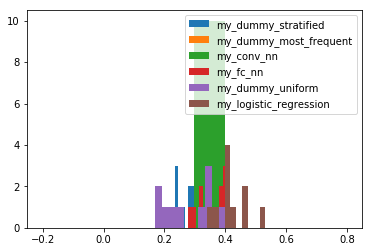

In [21]:
legend_names = []
for model_name, accuracy in accuracies.items():
    plt.hist(accuracy)
    print('{}:\t\t{} +- {}'.format(model_name, np.mean(accuracy), np.std(accuracy)))
    legend_names.append(model_name)
plt.legend(legend_names);

In [ ]:
# Only based on the content with test_fraction = 0.15 and runs = 30:

my_conv_nn:		0.3035714285714285 +- 5.551115123125783e-17
my_fc_nn:		0.25535714285714284 +- 0.04727929391026331
my_dummy_stratified:		0.31071428571428567 +- 0.03499271061118827
my_dummy_uniform:		0.2714285714285714 +- 0.0681385143869247
my_dummy_most_frequent:		0.3035714285714285 +- 5.551115123125783e-17
my_logistic_regression:		0.22678571428571428 +- 0.04229542600831075

my_conv_nn:		0.3035714285714286 +- 5.551115123125783e-17
my_fc_nn:		0.29642857142857143 +- 0.05658206970626735
my_dummy_stratified:		0.25357142857142856 +- 0.05578749768504753
my_dummy_uniform:		0.2720238095238095 +- 0.05526746448305267
my_dummy_most_frequent:		0.3035714285714286 +- 5.551115123125783e-17
my_logistic_regression:		0.3208333333333334 +- 0.0524654351176674


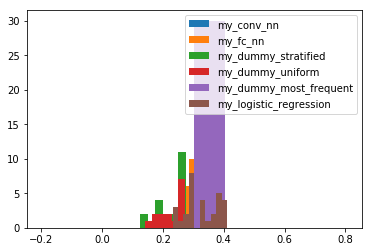

In [16]:
# legend_names = []
# for model_name, accuracy in accuracies.items():
#     plt.hist(accuracy)
#     print('{}:\t\t{} +- {}'.format(model_name, np.mean(accuracy), np.std(accuracy)))
#     legend_names.append(model_name)
# plt.legend(legend_names);

In [ ]:
# Only reply duration adjacency network with test_fraction = 0.15 and runs = 30:

my_conv_nn:		0.3035714285714286 +- 5.551115123125783e-17
my_fc_nn:		0.29642857142857143 +- 0.05658206970626735
my_dummy_stratified:		0.25357142857142856 +- 0.05578749768504753
my_dummy_uniform:		0.2720238095238095 +- 0.05526746448305267
my_dummy_most_frequent:		0.3035714285714286 +- 5.551115123125783e-17
my_logistic_regression:		0.3208333333333334 +- 0.0524654351176674

# Leave one out

In [58]:
with Timer():
    models = [my_logistic_regression, my_dummy_stratified, my_dummy_uniform, my_dummy_most_frequent]
    loo = LeaveOneOut()
    accuracies = defaultdict(list)
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(classification_data['X']):
        X_train, X_test = classification_data['X'][train_index], classification_data['X'][test_index]
        y_train, y_test = classification_data['y'][train_index], classification_data['y'][test_index]
        for model in models:
            accuracies[model.__name__].append(
                model(X_train, X_test, y_train, y_test))

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

It took 6.97 minutes.


In [65]:
legend_names = []
for model_name, accuracy in accuracies.items():
    print('{}:\t\t{}'.format(model_name, np.sum(accuracy) / len(accuracy)))

my_dummy_uniform:		0.26430517711171664
my_logistic_regression:		0.22070844686648503
my_dummy_most_frequent:		0.3133514986376022
my_dummy_stratified:		0.21525885558583105


In [ ]:
# Only based on the content with leave one out:

my_dummy_uniform:		0.26430517711171664
my_logistic_regression:		0.22070844686648503
my_dummy_most_frequent:		0.3133514986376022
my_dummy_stratified:		0.21525885558583105